---
title: Exploring BiG-SLICE query result
teaching: 0
exercises: 20
questions:
    - " How do I explore BiG-SLICE query result"
objectives:
    - Visualize query hits to BiG-FAM GCF models with Cytoscape
keypoints:
    - "BGCflow returns an edge table of your BGC query to the top 10 hits of GCF models in the BiG-FAM database"
---

In this episode, we will explore BiG-SLICE query hits of _S. venezuelae_ genomes with the [BiG-FAM database (version 1.0.0, run 6)](https://bigfam.bioinformatics.nl/home). You can download the `.ipynb` file of this episode and run it in your own directory.

If you're using the VM, activate the `bgc_analytics` conda environment by:
```bash
conda activate bgc_analytics 
```

Then, run jupyter lab with:
```bash
jupyter lab --no-browser
```

VS code will automatically forward a link that you can open in your local machine

### Table of Contents
1. [BGCflow Paths Configuration](#1)
2. [Raw BiG-SLICE query hits](#2)
3. [A glimpse of the data distribution](#3)
    - [Sanity Check: How many gene clusters predicted by antiSMASH?](#3.1)
    - [How many BGCs can be assigned to BiG-FAM gene cluster families?](#3.2)
    - [A closer look to BiG-FAM distributions](#3.3)
4. [Visualize BiG-FAM hits as network](#4)

### Libraries & Functions

In [1]:
# load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pathlib import Path
import json

ModuleNotFoundError: No module named 'seaborn'

In [2]:
# generate data
def gcf_hits(df_gcf, cutoff=900):
    """
    Filter bigslice result based on distance threshold to model and generate data.
    """
    mask = df_gcf.loc[:, "membership_value"] <= cutoff
    df_gcf_filtered = df_gcf[mask]
    bgcs = df_gcf_filtered.bgc_id.unique()
    gcfs = df_gcf_filtered.gcf_id.unique()
    print(
    f"""BiG-SLICE query with BiG-FAM run 6, distance cutoff {cutoff}
Number of bgc hits : {len(bgcs)}/{len(df_gcf.bgc_id.unique())}
Number of GCF hits : {len(gcfs)}""")
    return df_gcf_filtered

# visualization
def plot_overview(data):
    """
    Plot BGC hits distribution from BiG-SLICE Query
    """
    ranks = data.gcf_id.value_counts().index
    sns.set_theme()
    sns.set_context("paper")
    fig, axes = plt.subplots(1, 2, figsize=(25, 20))
    plt.figure(figsize = (25,25))

    # first plot
    sns.histplot(data=data, x='membership_value', 
                 kde=True, ax=axes[0],)

    # second plot
    sns.boxplot(data=data, y='gcf_id', x='membership_value', 
                orient='h', ax=axes[1], order=ranks)

    # Add in points to show each observation
    sns.stripplot(x="membership_value", y="gcf_id", data=data,
                  jitter=True, size=3, linewidth=0, color=".3", 
                  ax=axes[1], orient='h', order=ranks)
    return

## BGCflow Paths Configuration
Customize the cell below to your BGCflow result paths

In [3]:
# interim data
bigslice_query = Path("/datadrive/home/matinnu/bgcflow_data/interim/bigslice/query/s_venezuelae_antismash_6.0.1/")

# processed data
bigslice_query_processed = Path("/datadrive/bgcflow/data/processed/s_venezuelae/bigslice/query_as_6.0.1/")
bigscape_result = Path("/datadrive/home/matinnu/bgcflow_data/processed/s_venezuelae/bigscape/for_cytoscape_antismash_6.0.1/2022-06-21 02_46_35_df_clusters_0.30.csv")
gtdb_table = Path("/datadrive/home/matinnu/bgcflow_data/processed/s_venezuelae/tables/df_gtdb_meta.csv")

# output path
output_path = Path("../tables/bigslice")
output_path.mkdir(parents=True, exist_ok=True)

## Raw BiG-SLICE query hits
First, let's see the raw data from BiG-SLICE query hits. We have extracted individual tables from the SQL database.

In [4]:
! tree /datadrive/bgcflow/data/interim/bigslice/query/s_venezuelae_antismash_6.0.1/

/datadrive/bgcflow/data/interim/bigslice/query/s_venezuelae_antismash_6.0.1/
├── 1.db
├── bgc.csv
├── bgc_class.csv
├── bgc_features.csv
├── cds.csv
├── gcf_membership.csv
├── hsp.csv
├── hsp_alignment.csv
├── hsp_subpfam.csv
├── schema.csv
└── sqlite_sequence.csv

0 directories, 11 files


We will first look at these two tables:
- `bgc` table or the file `bgc.csv`
- `gcf_membership` table or the file `gcf_membership.csv`

The data from the interim folder has been processed for downstream analysis in the processed directory:

In [5]:
! tree /datadrive/bgcflow/data/processed/s_venezuelae/bigslice/query_as_6.0.1/

/datadrive/bgcflow/data/processed/s_venezuelae/bigslice/query_as_6.0.1/
├── gcf_summary.json
└── query_network.csv

0 directories, 2 files


In [6]:
# load the two tables
df_bgc = pd.read_csv(bigslice_query / "bgc.csv")
# BGC table from bigslice
df_bgc.loc[:, 'genome_id'] = [Path(i).name for i in df_bgc.orig_folder] # will be put in the main bgcflow code
# GCF membership table from bigslice
df_gcf_membership = pd.read_csv(bigslice_query / "gcf_membership.csv")

The `gcf_membership` table lists the top 10 closest BiG-FAM GCF models (order shown as `rank` column) and the euclidean distance to the model (`membership_value`). Smaller `membership_value` means that our BGC has a closer or more similar features with the models. Note that we are querying against run 6 in the BiG-FAM model, with threshold of 900, Therefore, if the `membership_value` is above 900, it is less likely that our BGC belongs to that gcf model.

In [7]:
df_gcf_membership.head()

,gcf_id,bgc_id,membership_value,rank
0,203601,448,669,0
1,208355,448,798,1
2,200946,448,826,2
3,207795,448,882,3
4,213140,448,885,4


The `bgc_id` column in `gcf_membership` table refers to the `id` column in `bgc` table. Therefore, we can enrich our hits with the metadata contained in `bgc` table

In [8]:
df_bgc.head()

,id,name,type,on_contig_edge,length_nt,orig_folder,orig_filename,genome_id
0,1,data/interim/bgcs/s_venezuelae/6.0.1/GCF_00863...,as6,0,29650,data/interim/bgcs/s_venezuelae/6.0.1/GCF_00863...,NZ_CP029197.1.region004.gbk,GCF_008639165.1
1,2,data/interim/bgcs/s_venezuelae/6.0.1/GCF_00870...,as6,0,11401,data/interim/bgcs/s_venezuelae/6.0.1/GCF_00870...,NZ_CP029195.1.region011.gbk,GCF_008705255.1
2,3,data/interim/bgcs/s_venezuelae/6.0.1/GCF_00025...,as6,0,10390,data/interim/bgcs/s_venezuelae/6.0.1/GCF_00025...,NC_018750.1.region027.gbk,GCF_000253235.1
3,4,data/interim/bgcs/s_venezuelae/6.0.1/GCF_02104...,as6,0,25706,data/interim/bgcs/s_venezuelae/6.0.1/GCF_02104...,NZ_JAJNOJ010000002.1.region009.gbk,GCF_021044745.1
4,5,data/interim/bgcs/s_venezuelae/6.0.1/GCF_00929...,as6,0,20390,data/interim/bgcs/s_venezuelae/6.0.1/GCF_00929...,NZ_CP023693.1.region020.gbk,GCF_009299385.1


## A glimpse of the data distribution
### Sanity Check: How many gene clusters predicted by antiSMASH?

In [9]:
print(f"There are {len(df_bgc)} BGCs predicted from {len(df_bgc.orig_folder.unique())} genomes.")

There are 515 BGCs predicted from 18 genomes.


### How many BGCs can be assigned to BiG-FAM gene cluster families?
BiG-SLICE calculate the feature distance of a BGC to BiG-FAM models (which is a centroid of each Gene Cluster Families generated from 1.2 million BGCs). Though it's not that accurate, it can give us a glimpse of the distribution of our BGCs within the database.

BiG-SLICE query with BiG-FAM run 6, distance cutoff 900
Number of bgc hits : 382/515
Number of GCF hits : 114
BiG-SLICE query with BiG-FAM run 6, distance cutoff 1200
Number of bgc hits : 487/515
Number of GCF hits : 220
BiG-SLICE query with BiG-FAM run 6, distance cutoff 1500
Number of bgc hits : 504/515
Number of GCF hits : 351


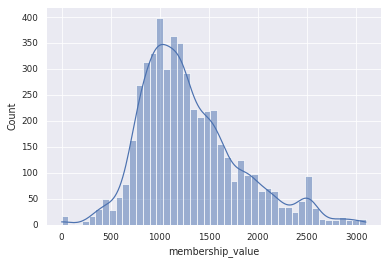

In [10]:
sns.set_theme()
sns.set_context("paper")
sns.histplot(df_gcf_membership, x='membership_value', kde=True)
for c in [900, 1200, 1500]:
    gcf_hits(df_gcf_membership, c)

Depending on the distance cutoffs, we can assign our BGCs to a different numbers of GCF model. The default cutoffs is 900 (run 6). In our data, 382 out of 515 BGCs can be assigned to 114 BiG-FAM GCF. Do note that the number of assigned GCF can be smaller if we only consider the first hit (the query returns 10 hits).

Smaller number means a closer distance to the GCF model. For further analysis, we will stick with the default cutoff.

### A closer look to BiG-FAM distributions
BGCflow already cleans the data for downstream processing. The processed bigslice query can be found in `bgcflow/data/processed/s_venezuelae/bigslice/query_as_6.0.1/`.

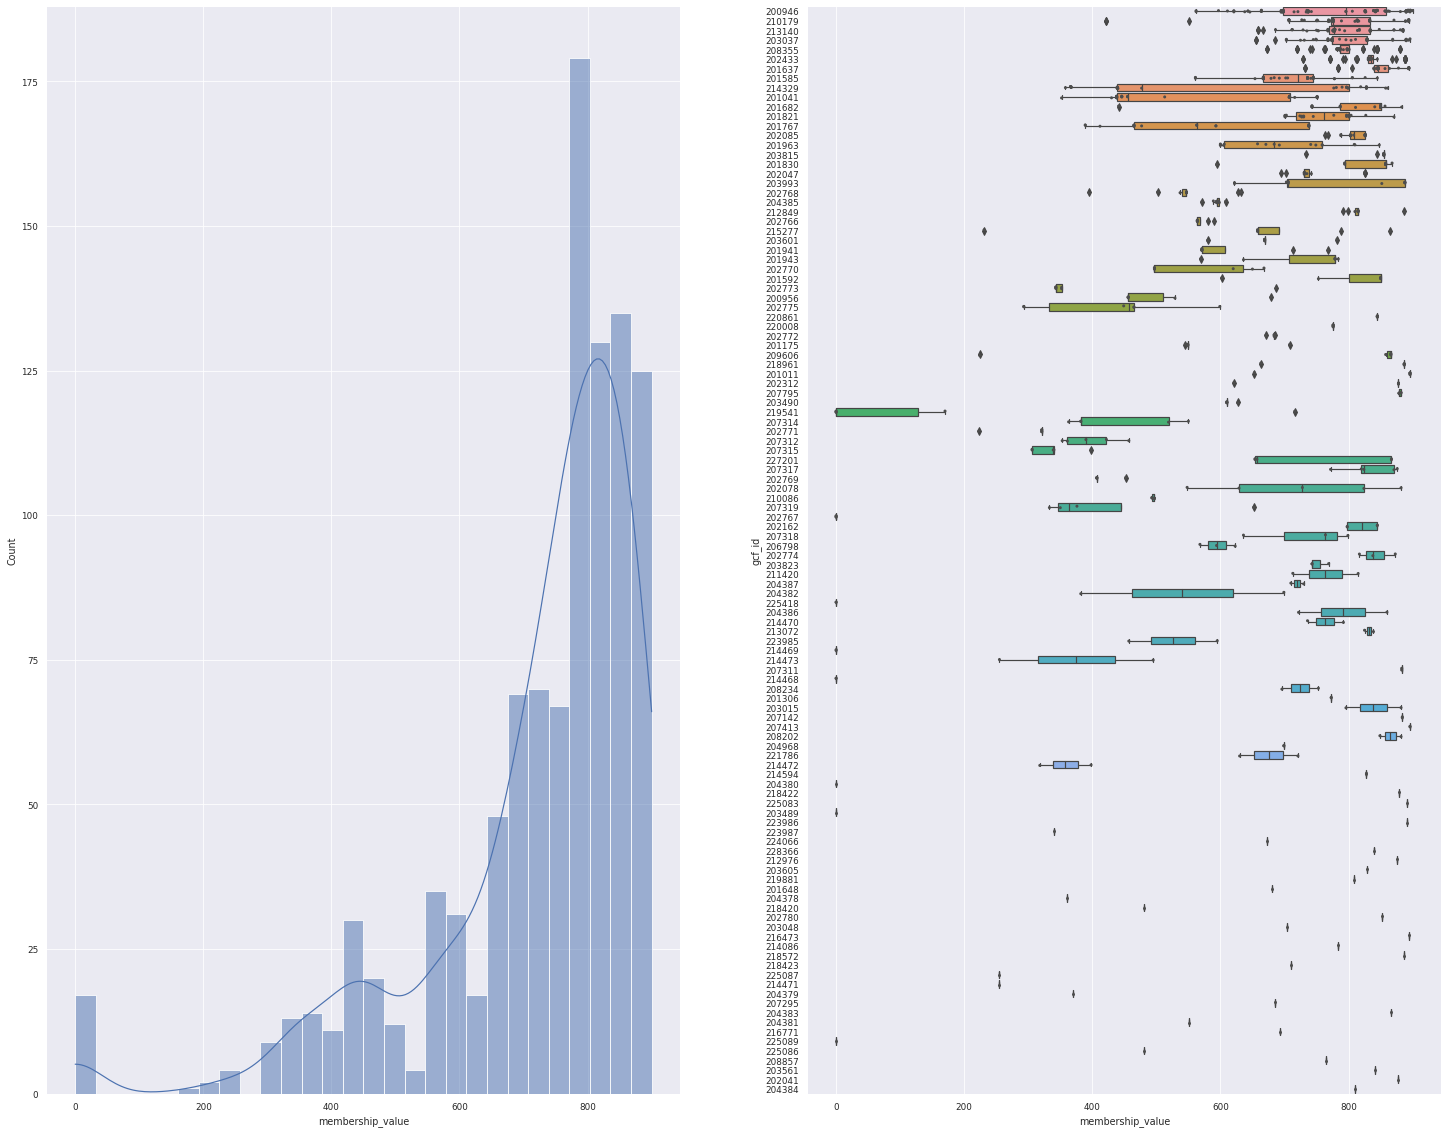

<Figure size 1800x1800 with 0 Axes>

In [11]:
data = pd.read_csv(bigslice_query_processed / "query_network.csv", index_col=0)
plot_overview(data)

On the figure above, we can see the distance distribution of our query to the model, and how each models have varying degree of distances. But, this data includes the top 10 hits, so 1 BGCs can be assigned to multiple GCFs.

Let's see again only for the first hit.

For the top 1 hit, 382 BGCs can be mapped to 83 GCF


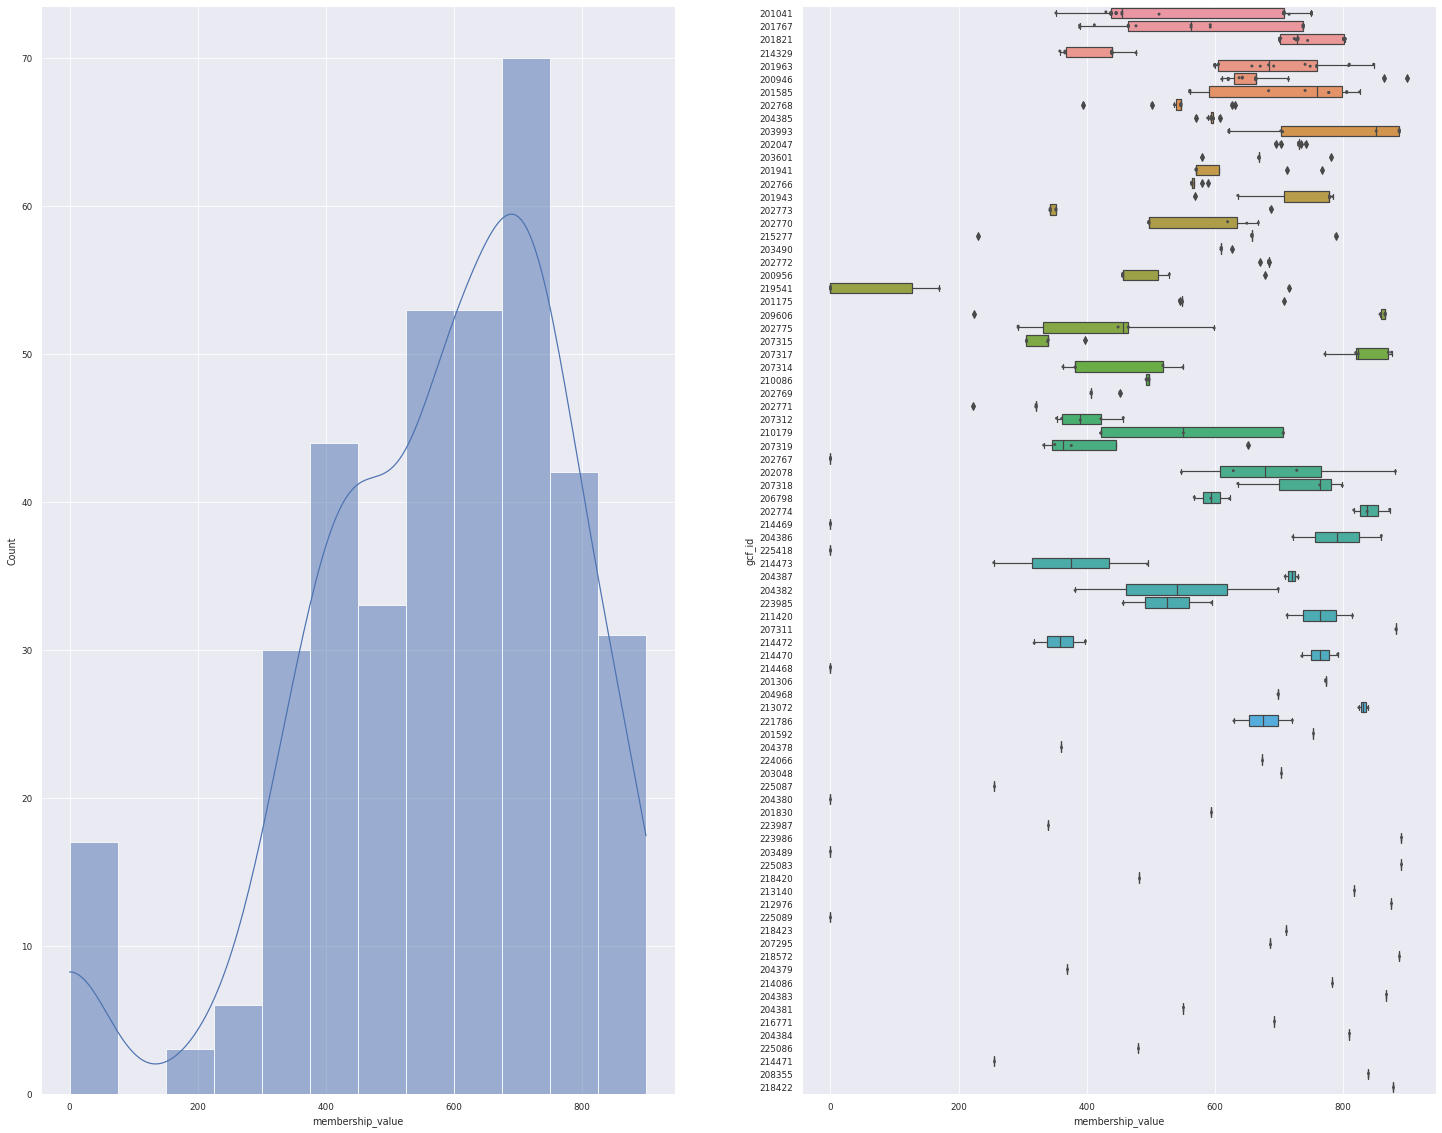

<Figure size 1800x1800 with 0 Axes>

In [12]:
n_hits = 1 # get only the first hit
n_hits_only = data.loc[:, "rank"].isin(np.arange(n_hits))
data_1 = data[n_hits_only]
print(f"For the top {n_hits} hit, {len(data_1.bgc_id.unique())} BGCs can be mapped to {len(data_1.gcf_id.unique())} GCF")
plot_overview(data_1)

# Visualize BiG-FAM hits as network
## Visualize network in Cytoscape
One way that can be useful to navigate the result is to visualize the hits as a network enriched with metadata from antiSMASH and BiG-SCAPE. Here, we will prepare a matrix required for network analysis in Cytoscape

In [13]:
data.to_csv("../tables/bigslice/query_network.csv", index=False)

A network can be generated from the file `query_network.csv` by using the value from `bgc_name` as source and `gcf_id` as target.

***TO DO***
- [ ] Tutorial Cytoscape
- importing network

## Annotate with metadata from BiG-SCAPE and GTDB
These network will only be meaningful when we enrich it with metadata. We can use information from our BiG-SCAPE runs, taxonomic information from GTDB-tk, and other tables generated by BGCflow. 

In [14]:
# Enrich with BiG-SCAPE
df_annotation = pd.read_csv(bigscape_result, index_col=0)
df_annotation.loc[:, "bigslice_query"] = "query"
for i in data["gcf_id"].unique():
    df_annotation.loc[i, "bigslice_query"] = "model"

# enrich with GTDB
df_gtdb = pd.read_csv(gtdb_table).set_index("genome_id")
for i in df_annotation.index:
    genome_id = df_annotation.loc[i, "genome_id"]
    if type(genome_id) == str:
        for item in ["gtdb_release", "Domain", "Phylum", "Class", "Order", "Family", "Genus", "Species", "Organism"]:
            df_annotation.loc[i, item] = df_gtdb.loc[genome_id, item]

# enrich with bgc info - will be put in the main bgcflow code
bgc_info = df_bgc.copy()
bgc_info["bgc_id"] = [str(i).replace(".gbk", "") for i in bgc_info["orig_filename"]]
bgc_info = bgc_info.set_index("bgc_id")
for i in df_annotation.index:
    try:
        df_annotation.loc[i, "on_contig_edge"] = bgc_info.loc[i, "on_contig_edge"]
        df_annotation.loc[i, "length_nt"] = bgc_info.loc[i, "length_nt"]
    except KeyError:
        pass

In [15]:
df_annotation.head()

,product,bigscape_class,genome_id,accn_id,gcf_0.30,gcf_0.40,gcf_0.50,Clan Number,fam_id_0.30,fam_type_0.30,...,Domain,Phylum,Class,Order,Family,Genus,Species,Organism,on_contig_edge,length_nt
NC_018750.1.region001,ectoine,Others,GCF_000253235.1,NC_018750.1,1911.0,1911.0,1911.0,2045.0,2.0,known_family,...,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Streptomycetales,f__Streptomycetaceae,g__Streptomyces,venezuelae,s__Streptomyces venezuelae,0.0,10417.0
NC_018750.1.region002,terpene,Terpene,GCF_000253235.1,NC_018750.1,2109.0,2109.0,2109.0,NaN,14.0,unknown_family,...,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Streptomycetales,f__Streptomycetaceae,g__Streptomyces,venezuelae,s__Streptomyces venezuelae,0.0,20954.0
NC_018750.1.region003,T3PKS.NRPS.NRPS-like.T1PKS,PKS-NRP_Hybrids,GCF_000253235.1,NC_018750.1,1913.0,1913.0,1913.0,NaN,22.0,known_family,...,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Streptomycetales,f__Streptomycetaceae,g__Streptomyces,venezuelae,s__Streptomyces venezuelae,0.0,99490.0
NC_018750.1.region004,terpene.lanthipeptide-class-ii,Others,GCF_000253235.1,NC_018750.1,2111.0,2111.0,2111.0,36.0,20.0,unknown_family,...,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Streptomycetales,f__Streptomycetaceae,g__Streptomyces,venezuelae,s__Streptomyces venezuelae,0.0,29652.0
NC_018750.1.region005,lanthipeptide-class-iv,RiPPs,GCF_000253235.1,NC_018750.1,2399.0,2399.0,2399.0,552.0,17.0,known_family,...,d__Bacteria,p__Actinobacteriota,c__Actinomycetia,o__Streptomycetales,f__Streptomycetaceae,g__Streptomyces,venezuelae,s__Streptomyces venezuelae,0.0,22853.0


### Annotate models with information from BiG-FAM db
From the step above, we have enriched the query nodes with metadata, but we are still lacking the information about the models. Let's enrich the models with the json file generated by BGCflow.

In [16]:
bigfam_hits = pd.read_json(bigslice_query_processed / "gcf_summary.json").T
bigfam_hits.head()

,core_member,putative_member,core_member_mibig,putative_member_mibig,core_member_mibig_count,putative_member_mibig_count,link to BiG-FAM
203601,1406,201,"[BGC0000850.1, BGC0000849.1, BGC0000848.1]",[],3,0,https://bigfam.bioinformatics.nl/run/6/gcf/203601
208355,6440,3186,"[BGC0000595.1, BGC0000596.1, BGC0000933.1, BGC...","[BGC0001137.1, BGC0001295.1]",6,2,https://bigfam.bioinformatics.nl/run/6/gcf/208355
200946,131525,4659,"[BGC0001286.1, BGC0001864.1, BGC0002005.1, BGC...","[BGC0000736.1, BGC0000883.1, BGC0000765.1, BGC...",124,29,https://bigfam.bioinformatics.nl/run/6/gcf/200946
207795,192,346,[],[BGC0001476.1],0,1,https://bigfam.bioinformatics.nl/run/6/gcf/207795
213140,1871,1165,"[BGC0001928.1, BGC0001893.1, BGC0001605.1, BGC...","[BGC0001882.1, BGC0001985.1, BGC0000887.1, BGC...",9,9,https://bigfam.bioinformatics.nl/run/6/gcf/213140


In [21]:
with open(bigslice_query_processed / "gcf_summary.json") as json_file:
    data = json.load(json_file)
pd.DataFrame.from_dict(data).T

,core_member,putative_member,core_member_mibig,putative_member_mibig,core_member_mibig_count,putative_member_mibig_count,link to BiG-FAM
203601,1406,201,"[BGC0000850.1, BGC0000849.1, BGC0000848.1]",[],3,0,https://bigfam.bioinformatics.nl/run/6/gcf/203601
208355,6440,3186,"[BGC0000595.1, BGC0000596.1, BGC0000933.1, BGC...","[BGC0001137.1, BGC0001295.1]",6,2,https://bigfam.bioinformatics.nl/run/6/gcf/208355
200946,131525,4659,"[BGC0001286.1, BGC0001864.1, BGC0002005.1, BGC...","[BGC0000736.1, BGC0000883.1, BGC0000765.1, BGC...",124,29,https://bigfam.bioinformatics.nl/run/6/gcf/200946
207795,192,346,[],[BGC0001476.1],0,1,https://bigfam.bioinformatics.nl/run/6/gcf/207795
213140,1871,1165,"[BGC0001928.1, BGC0001893.1, BGC0001605.1, BGC...","[BGC0001882.1, BGC0001985.1, BGC0000887.1, BGC...",9,9,https://bigfam.bioinformatics.nl/run/6/gcf/213140
...,...,...,...,...,...,...,...
214473,1,5,[],[],0,0,https://bigfam.bioinformatics.nl/run/6/gcf/214473
204378,1,0,[],[],0,0,https://bigfam.bioinformatics.nl/run/6/gcf/204378
204386,2,1,[],[],0,0,https://bigfam.bioinformatics.nl/run/6/gcf/204386
202769,6,1,[],[],0,0,https://bigfam.bioinformatics.nl/run/6/gcf/202769


The JSON file summarizes the information of a model:
- **core_member**: number of member with threshold <= 900
- **putative_member**: number of member with threshold > 900
- **core_member_mibig**: list of MIBIG ids which part of the core member
- **putative_member_mibig**: list of MIBIG ids which part of the putative member
- **link to BiG-FAM**: a link to detailed information of each models in https://bigfam.bioinformatics.nl

Let's add those information to our annotation file:

In [17]:
df_annotation = pd.concat([df_annotation, bigfam_hits], axis=1)

In [18]:
df_annotation.to_csv("../tables/bigslice/query_annotation.csv")

# To Do
- [ ] Tutorial Cytoscape
- importing annotation
- importing styles
- filtering
- explore the data

## General
- Automate network vis
- Does the GCF makes sense?
- We are using as6 while the model was built using as5. How do you think this will affect the analysis?

## GCF table
- Enrich GCF info from BiG-FAM
- GCF member size?
- Link to BiG-FAM
- Which GCF has MiBiG hits on it?
- What is the taxonomic distribution of the GCF?